In [1]:
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim import models as gs
import gensim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


nltk.download(['stopwords', 'wordnet', 'punkt'])

True


In [2]:
df = pd.read_csv("data/Articles.csv", encoding='latin1')
df.shape

(2692, 4)

In [3]:

def preprocess_text(text):

    # Replace non-ASCII characters, punctuations, numbers, and new lines with space
    text = re.sub(r'[^\x00-\x7F]+|[' + string.punctuation + string.digits + ']|[\n\r]', ' ', text)
    
    # Convert multiple spaces to single space
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

def remove_stopwords_using_tokenization(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

df["processed_articles"] = df["Article"].str.lower()
df['processed_articles'] = df['processed_articles'].apply(preprocess_text)
df['processed_articles'] = df['processed_articles'].apply(remove_stopwords_using_tokenization)



In [4]:


text_data = list(df['processed_articles'].to_numpy())


tokens = [gs.utils.simple_preprocess(t) for t in text_data]


bigram = gs.models.Phrases(tokens, min_count=5, threshold=25) 
bigram_model = gs.models.phrases.Phraser(bigram)


bigrams = [bigram_model[doc] for doc in tokens]


id2word = gs.corpora.Dictionary(bigrams)
corpus = [id2word.doc2bow(text) for text in bigrams] 

### Hyperparameter Tunning

In [14]:
models_by_topics = dict()
topics_range = range(12,18)
optimal_model = None
best_coherence_score = 0

passes_range = [15]  
chunksize_range = [20, 40, 60]  
alpha_options = ['asymmetric']  

for tn in topics_range:
    for passes_val in passes_range:
        for chunksize_val in chunksize_range:
            for alpha_val in alpha_options:
                print(f"Topics: {tn}, Passes: {passes_val}, Chunksize: {chunksize_val}, Alpha: {alpha_val}")
                lda_model = gensim.models.LdaMulticore(
                    corpus=corpus,
                    id2word=id2word,
                    num_topics=tn,
                    random_state=33,
                    chunksize=chunksize_val,
                    passes=passes_val,
                    alpha=alpha_val,
                    per_word_topics=True
                )
                
                coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=bigrams, dictionary=id2word, coherence='c_v')
                coherence_score = coherence_model_lda.get_coherence()

                
                if coherence_score > best_coherence_score:
                    best_coherence_score = coherence_score
                    optimal_model = lda_model
                
                models_by_topics[(tn, passes_val, chunksize_val, alpha_val)] = {
                    'model': lda_model,
                    'coherence_score': coherence_score
                }


Topics: 12, Passes: 15, Chunksize: 20, Alpha: asymmetric
Topics: 12, Passes: 15, Chunksize: 40, Alpha: asymmetric
Topics: 12, Passes: 15, Chunksize: 60, Alpha: asymmetric
Topics: 13, Passes: 15, Chunksize: 20, Alpha: asymmetric
Topics: 13, Passes: 15, Chunksize: 40, Alpha: asymmetric
Topics: 13, Passes: 15, Chunksize: 60, Alpha: asymmetric
Topics: 14, Passes: 15, Chunksize: 20, Alpha: asymmetric
Topics: 14, Passes: 15, Chunksize: 40, Alpha: asymmetric
Topics: 14, Passes: 15, Chunksize: 60, Alpha: asymmetric
Topics: 15, Passes: 15, Chunksize: 20, Alpha: asymmetric
Topics: 15, Passes: 15, Chunksize: 40, Alpha: asymmetric
Topics: 15, Passes: 15, Chunksize: 60, Alpha: asymmetric
Topics: 16, Passes: 15, Chunksize: 20, Alpha: asymmetric
Topics: 16, Passes: 15, Chunksize: 40, Alpha: asymmetric
Topics: 16, Passes: 15, Chunksize: 60, Alpha: asymmetric
Topics: 17, Passes: 15, Chunksize: 20, Alpha: asymmetric
Topics: 17, Passes: 15, Chunksize: 40, Alpha: asymmetric
Topics: 17, Passes: 15, Chunksi

### Saving the state

In [16]:
import pickle

file_path = 'output/model_training_state.pickle'

with open(file_path, 'wb') as f: pickle.dump(models_by_topics, f)

print("Dictionary saved as pickle file.")


Dictionary saved as pickle file.


In [6]:
coherence_scores_metrics ={"hyperparameter_key":[],"topic_num":[],"passes_num":[],"chunksize":[],"alpha":[], "coherence_score":[]}

for key, items in models_by_topics.items():
    hyperparameter_key = "-".join([f"{each}" for each in key])

    coherence_scores_metrics["hyperparameter_key"].append(hyperparameter_key)

    coherence_scores_metrics["topic_num"].append(hyperparameter_key.split("-")[0])

    coherence_scores_metrics["passes_num"].append(hyperparameter_key.split("-")[1])

    coherence_scores_metrics["chunksize"].append(hyperparameter_key.split("-")[2])

    coherence_scores_metrics["alpha"].append(hyperparameter_key.split("-")[3])

    coherence_scores_metrics["coherence_score"].append(items["coherence_score"])

    

coherence_scores_metrics_df = pd.DataFrame.from_dict(coherence_scores_metrics)
coherence_scores_metrics_df = coherence_scores_metrics_df.sort_values(by='coherence_score', ascending=False).reset_index(drop=True)
coherence_scores_metrics_df.to_excel("output/coherence_scores.xlsx", index=False)
coherence_scores_metrics_df

,hyperparameter_key,topic_num,passes_num,chunksize,alpha,coherence_score
0,14-15-60-asymmetric,14,15,60,asymmetric,0.465887


### Picking the best model

In [7]:
optimal_hyperparameter_key = '14-15-60-asymmetric'
optimal_model=None
for key, items in models_by_topics.items():
    hyperparameter_key = "-".join([f"{each}" for each in key])
    if(hyperparameter_key==optimal_hyperparameter_key):
        optimal_model = items["model"]
        break

optimal_model.save(f"models/{optimal_hyperparameter_key}.model")


### Tagging

In [ ]:
topic_terms = dict()
top_n = 10
for n in range(optimal_model.num_topics):
  topic_terms[n] = dict()
  for id, prob in optimal_model.get_topic_terms(topicid=n, topn=top_n):
    topic_terms[n][id2word[id]] = prob

In [ ]:
import pickle

file_path = 'output/topic_terms.pickle'

with open(file_path, 'wb') as f: pickle.dump(topic_terms, f)

print("Dictionary saved as pickle file.")


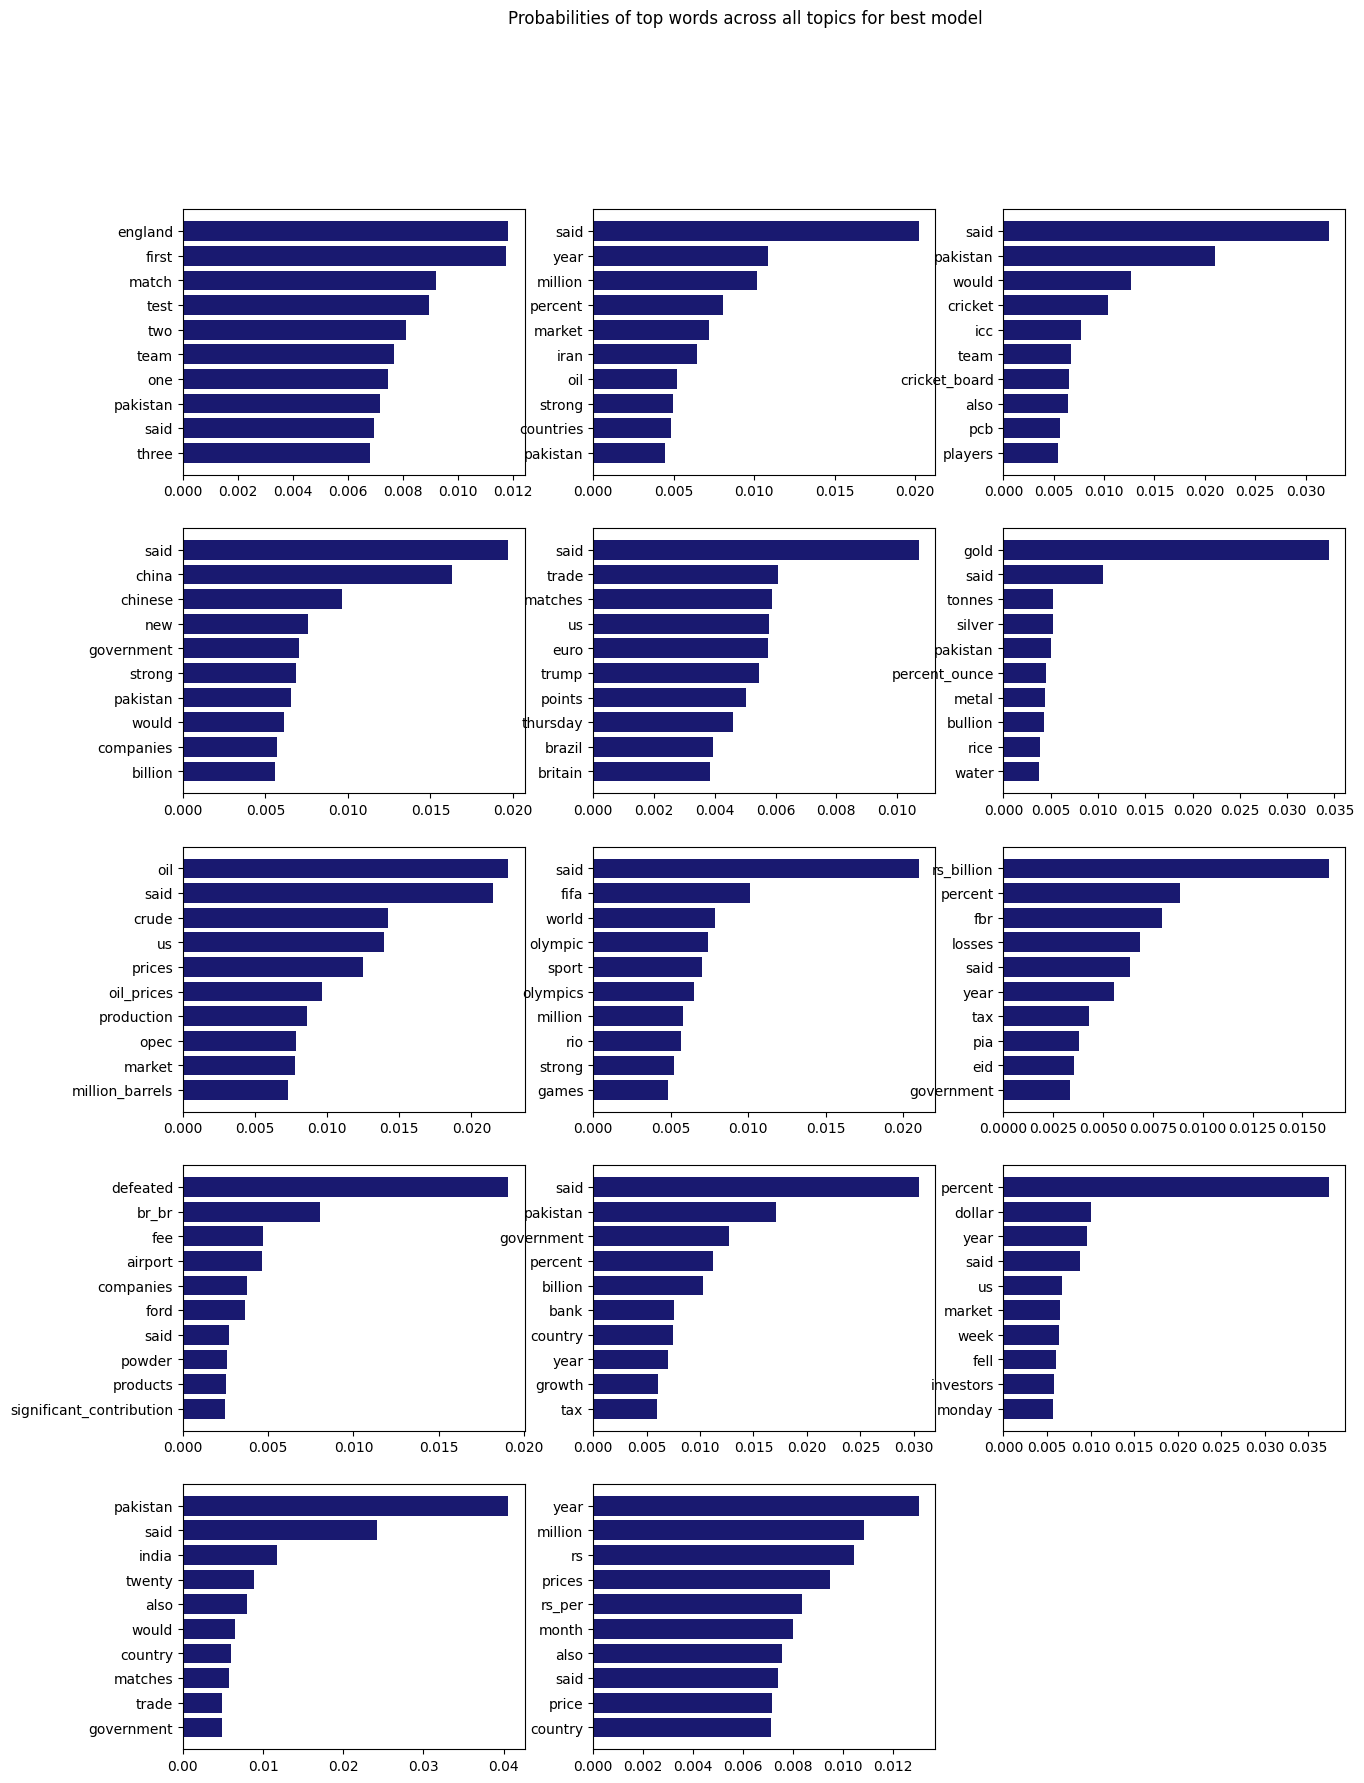

In [8]:



cols = 3
rows = optimal_model.num_topics//cols + 1
fig, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*4))

for a in range(optimal_model.num_topics):
  axs[a//cols, a%cols].barh(y=np.arange(top_n), width=list(topic_terms[a].values()), color='midnightblue' )
  axs[a//cols, a%cols].set_yticks(np.arange(top_n))
  axs[a//cols, a%cols].set_yticklabels(labels=list(topic_terms[a].keys()))
  axs[a//cols, a%cols].invert_yaxis()

for b in range(optimal_model.num_topics, rows*cols):
  axs[b//cols, b%cols].set_axis_off()

fig.suptitle('Probabilities of top words across all topics for best model')
plt.show()

In [9]:
for idx, topic in optimal_model.print_topics(-1):
    print(f"Topic num:{idx} and words: {topic}","\n")


Topic num:0 and words: 0.012*"england" + 0.012*"first" + 0.009*"match" + 0.009*"test" + 0.008*"two" + 0.008*"team" + 0.007*"one" + 0.007*"pakistan" + 0.007*"said" + 0.007*"three" 

Topic num:1 and words: 0.020*"said" + 0.011*"year" + 0.010*"million" + 0.008*"percent" + 0.007*"market" + 0.006*"iran" + 0.005*"oil" + 0.005*"strong" + 0.005*"countries" + 0.004*"pakistan" 

Topic num:2 and words: 0.032*"said" + 0.021*"pakistan" + 0.013*"would" + 0.010*"cricket" + 0.008*"icc" + 0.007*"team" + 0.007*"cricket_board" + 0.006*"also" + 0.006*"pcb" + 0.005*"players" 

Topic num:3 and words: 0.020*"said" + 0.016*"china" + 0.010*"chinese" + 0.008*"new" + 0.007*"government" + 0.007*"strong" + 0.007*"pakistan" + 0.006*"would" + 0.006*"companies" + 0.006*"billion" 

Topic num:4 and words: 0.011*"said" + 0.006*"trade" + 0.006*"matches" + 0.006*"us" + 0.006*"euro" + 0.005*"trump" + 0.005*"points" + 0.005*"thursday" + 0.004*"brazil" + 0.004*"britain" 

Topic num:5 and words: 0.034*"gold" + 0.011*"said" + 

In [10]:

doc_topic_cons = optimal_model.get_document_topics(bow=corpus)
doc_topic_cons = [sorted(cons, key=lambda x:x[1], reverse=True) for cons in doc_topic_cons]



topics_n_cons = dict({
  'Topic': [vals[0][0] for vals in doc_topic_cons],
  'Contribution': [vals[0][1] for vals in doc_topic_cons]
})
df_tagged = pd.DataFrame.from_dict(topics_n_cons)
df_tagged['text'] = df['Article'].copy()


topic_words = []
for i, doc in enumerate(corpus):
    topic_id = df_tagged.at[i, 'Topic']
    topic_words.append([word for word, _ in optimal_model.show_topic(topic_id)])

df_tagged['Topic_Words'] = topic_words

df_tagged.head()

,Topic,Contribution,text,Topic_Words
0,13,0.546512,KARACHI: The Sindh government has decided to b...,"[year, million, rs, prices, rs_per, month, als..."
1,11,0.734199,HONG KONG: Asian markets started 2015 on an up...,"[percent, dollar, year, said, us, market, week..."
2,11,0.592040,HONG KONG: Hong Kong shares opened 0.66 perce...,"[percent, dollar, year, said, us, market, week..."
3,11,0.535315,HONG KONG: Asian markets tumbled Tuesday follo...,"[percent, dollar, year, said, us, market, week..."
4,6,0.668254,NEW YORK: US oil prices Monday slipped below $...,"[oil, said, crude, us, prices, oil_prices, pro..."


In [11]:
df_tagged.to_csv("output/tagged_data.csv", index=False)